In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
import json
import time
import warnings

from bs4 import BeautifulSoup
from tqdm import tqdm
import requests

from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
import plotly.express as px
from tqdm.autonotebook import tqdm

import openpyxl 
import pycountry
from googletrans import Translator

import nltk
#nltk.download()


warnings.filterwarnings('ignore')

## Análsis exploratorio

In [18]:
net = pd.read_csv('../data/raw/Net_titles.csv', encoding='utf-8', encoding_errors='ignore')
hbo = pd.read_csv('../data/raw/HBO_titles.csv', encoding='utf-8', encoding_errors='ignore') 
amazon = pd.read_csv('../data/raw/Ama_titles.csv', encoding='utf-8', encoding_errors='ignore')

In [19]:
net.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [20]:
hbo.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,tm77588,Casablanca,MOVIE,"In Casablanca, Morocco in December 1941, a cyn...",1943,PG,102,"['drama', 'romance', 'war']",['US'],NaN,tt0034583,8.5,577842.0,22.005,8.167
1,tm155702,The Wizard of Oz,MOVIE,Young Dorothy finds herself in a magical world...,1939,G,102,"['fantasy', 'family']",['US'],NaN,tt0032138,8.1,406105.0,56.631,7.583
2,tm83648,Citizen Kane,MOVIE,"Newspaper magnate, Charles Foster Kane is take...",1941,PG,119,['drama'],['US'],NaN,tt0033467,8.3,446627.0,19.900,8.022
3,tm3175,Meet Me in St. Louis,MOVIE,In the year before the 1904 St. Louis World's ...,1945,NaN,113,"['drama', 'family', 'romance', 'music', 'comedy']",['US'],NaN,tt0037059,7.5,25589.0,8.311,7.000
4,ts225761,Tom and Jerry,SHOW,Tom and Jerry is an American animated franchis...,1940,NaN,8,"['animation', 'comedy', 'family', 'action']",['US'],16.0,tt6422744,7.7,859.0,1.400,10.000


In [21]:
amazon.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,tm87233,It's a Wonderful Life,MOVIE,A holiday favourite for generations... George...,1946,PG,130,"['drama', 'family', 'fantasy', 'romance', 'com...",['US'],NaN,tt0038650,8.6,467766.0,27.611,8.261
1,tm143047,Duck Soup,MOVIE,Rufus T. Firefly is named president/dictator o...,1933,NaN,69,"['comedy', 'war']",['US'],NaN,tt0023969,7.8,60933.0,9.013,7.357
2,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,NaN,92,"['drama', 'romance', 'comedy']",['US'],NaN,tt0032599,7.8,60244.0,14.759,7.433
3,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934,TV-PG,19,"['comedy', 'family']",['US'],26.0,tt0850645,8.5,1149.0,15.424,7.600
4,tm5012,Red River,MOVIE,Headstrong Thomas Dunson starts a thriving Tex...,1948,NaN,133,"['western', 'drama', 'romance', 'action']",['US'],NaN,tt0040724,7.8,32210.0,12.400,7.400


In [7]:
# Crear un df con las plataformas de cada pelicula
net['platforms_list'] = 'Netflix'
hbo['platforms_list'] = 'HBO'
amazon['platforms_list'] = 'Amazon'


In [9]:
titles = pd.concat([net, hbo, amazon], ignore_index=True)


In [10]:
titles = titles.groupby('title')['platforms_list'].apply(', '.join).reset_index()


In [11]:
titles['platform'] = titles['platforms_list'].apply(lambda x: ', '.join(set(x.split(', '))))


In [12]:
titles = titles.drop('platforms_list', axis=1)


In [16]:
titles


,title,platform
0,#ABtalks,Netflix
1,#Alive,Netflix
2,#AnneFrank. Parallel Stories,Netflix
3,#FriendButMarried,Netflix
4,#FriendButMarried 2,Netflix
...,...,...
19038,糖糖Online,Netflix
19039,냉면 랩소디,Netflix
19040,마법버스 타요,Netflix
19041,부릉! 부릉! 브루미즈,Amazon


In [17]:
titles.to_csv('../data/raw/film_platform.csv', index=False)

In [24]:
# unir dataframes
titles = pd.concat([net, hbo, amazon], ignore_index=True)

In [26]:
platform = pd.read_csv('../data/raw/film_platform.csv', encoding='utf-8', encoding_errors='ignore')

In [27]:
titles = pd.merge(titles, platform[['title', 'platform']], on='title', how='left')


In [79]:
titles = titles.drop_duplicates(subset='imdb_id')


In [43]:
titles.head()


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN,Netflix
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,"Netflix, HBO"
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,Netflix
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,Netflix
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,"Netflix, HBO"


## Limpieza de datos: limpieza de nulos y valores inconsistentes

<Axes: >

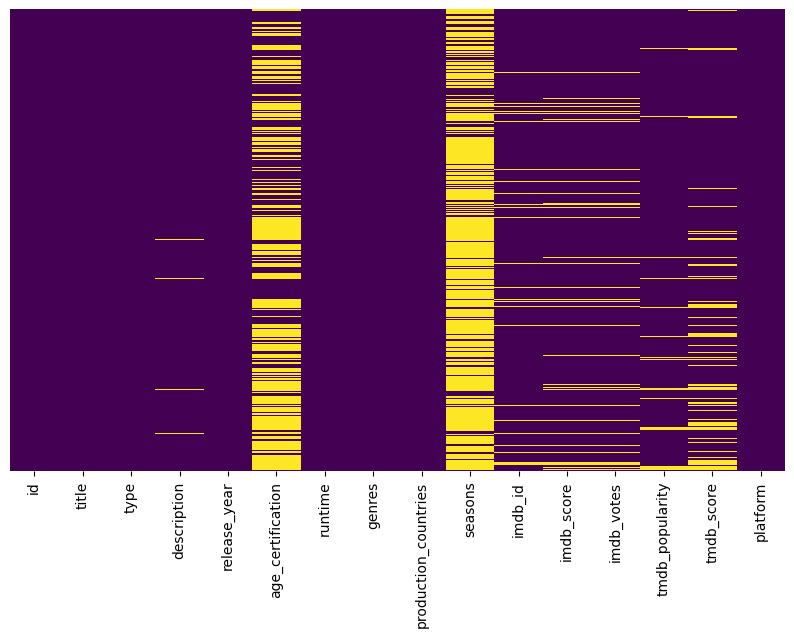

In [44]:
# gráfico de nulos tabla titles
plt.figure(figsize=(10, 6))

sns.heatmap(titles.isna(),    
                yticklabels=False,  
                cmap='viridis',     
                cbar=False,         
               )

In [45]:
# porcentaje de nulos de la tabla Titles
nan_cols = titles.isna().mean() * 100 
nan_cols[nan_cols>0]

title                 0.005125
description           0.876429
age_certification    55.594280
seasons              78.468556
imdb_id               6.934550
imdb_score            9.599713
imdb_votes            9.830352
tmdb_popularity       3.469838
tmdb_score           13.341192
platform              0.005125
dtype: float64

In [50]:
titles['age_certification'].value_counts()

age_certification
R           2466
PG-13       1491
TV-MA       1406
PG          1091
TV-14        818
G            441
TV-PG        342
TV-Y7        209
TV-Y         195
TV-G         162
NC-17         36
TV-Y7-FV       7
Name: count, dtype: int64

In [51]:
# rellenar los valores nulos de la columna Age_certification. Si pertenece a los siguientes géneros se asumirá que la certificación de edad es R (+17)
def fill_age_null(row):
    if pd.isna(row['age_certification']):
        if 'thriller' in row['genres'] or 'horror' in row['genres'] in row['genres']:
            return 'R'
    return row['age_certification']

titles['age_certification'] = titles.apply(lambda row: fill_age_null(row), axis=1)

In [56]:
# Eliminar los valores nulos de las columnas relacionados con IMDB y TMDB, ya que sin el imdb_id es imposible analizarlos
# Rellenar los valores nulos de la columna seasons con '-1'
# rellenar el resto de valores nulos (37.343342% de nulos en la columna age_certification y 0.095426% en la columna description) con la palabra 'unknown'

titles.dropna(subset=['imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score'], inplace=True)
titles['seasons'] = titles['seasons'].fillna('-1')
titles = titles.fillna('unknown')

In [59]:
# cambiar formato de la columna production_countries
titles['production_countries'] = titles['production_countries'].astype(str).str.strip("[]").str.replace("'", "").str.split(", ")
titles['production_countries'] = titles['production_countries'].apply(lambda x: ", ".join([pycountry.countries.get(alpha_2=code).name if pycountry.countries.get(alpha_2=code) else code for code in x]))

In [61]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",United States,-1,tt0075314,8.2,808582.0,40.965,8.179,"Netflix, HBO"
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",United States,-1,tt0068473,7.7,107673.0,10.010,7.300,Netflix
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",United Kingdom,-1,tt0071853,8.2,534486.0,15.461,7.811,Netflix
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"['war', 'action']","United Kingdom, United States",-1,tt0061578,7.7,72662.0,20.398,7.600,"Netflix, HBO"
5,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",United Kingdom,4.0,tt0063929,8.8,73424.0,17.617,8.306,Netflix


In [62]:
titles["tmdb_score"] = titles["tmdb_score"].round(1)                                 # redondear score

titles['imdb_votes'] = titles['imdb_votes'].astype(str)
titles["imdb_votes"] = pd.to_numeric(titles["imdb_votes"].str.replace(".0", ""))     # cambiar formato imdb_votes

titles['tmdb_popularity'] = titles['tmdb_popularity'].astype(str)                    # cambiar formato tmdb_popularity
titles["tmdb_popularity"] = pd.to_numeric(titles["tmdb_popularity"].str.replace(".", ""))  

titles = titles.rename(columns={'tmdb_popularity':'tmdb_votes'})                     # cambiar el nombre de la columna tmdb_popularity

In [72]:
# cambiar el formato de la columna genres
titles['genres'] = titles['genres'].astype(str).str.strip('[]').str.replace("'", '').str.split(', ')
titles['genres'] = titles['genres'].astype(str).str.replace('[', '').str.replace(']', '')
titles['genres'] = titles['genres'].str.replace("'", "")



In [74]:
titles.to_csv('../data/clean/titles.csv', index=False)

## Extracción de comentarios

In [3]:
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

In [4]:
titles

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO"
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO"
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15714,tm948025,Hard Luck Love Song,MOVIE,"Jesse, a charismatic but down on his luck trou...",2023,R,104,"drama, thriller, romance, music",United States,-1.0,tt8709338,5.3,444,4299,5.3,Amazon
15715,tm811070,The Man on the Other Side,MOVIE,"It is 1974, and in the Cold War paranoia of Ea...",2023,R,85,"action, drama, thriller","United Kingdom, Singapore, Germany",-1.0,tt8000096,4.6,189,3415,2.0,Amazon
15716,ts382337,Marc Marquez: ALL IN,SHOW,Marc Márquez is facing the toughest decision o...,2023,unknown,33,documentation,Spain,1.0,tt26762647,8.1,74,2893,6.0,Amazon
15717,tm1292884,Hunt,MOVIE,"Arjun is the ACP of Hyderabad, who gets involv...",2023,R,129,"action, thriller, crime",India,-1.0,tt21946058,5.8,1269,4403,4.3,Amazon


In [5]:
ama = titles[titles['platform'] == 'Amazon']

In [6]:
ama = ama[ama['release_year'] <= 2000]      # divido el número de películas en dos grupos, antes y después del 2000, para escrapear los comentarios y reviews sin llegar al número máximo de solicitudes


In [7]:
ama

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform
7691,tm87233,It's a Wonderful Life,MOVIE,A holiday favourite for generations... George...,1946,PG,130,"drama, family, fantasy, romance, comedy",United States,-1.0,tt0038650,8.6,467766,27611,8.3,Amazon
7692,tm143047,Duck Soup,MOVIE,Rufus T. Firefly is named president/dictator o...,1933,unknown,69,"comedy, war",United States,-1.0,tt0023969,7.8,60933,9013,7.4,Amazon
7693,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,unknown,92,"drama, romance, comedy",United States,-1.0,tt0032599,7.8,60244,14759,7.4,Amazon
7694,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934,TV-PG,19,"comedy, family",United States,26.0,tt0850645,8.5,1149,15424,7.6,Amazon
7695,tm5012,Red River,MOVIE,Headstrong Thomas Dunson starts a thriving Tex...,1948,unknown,133,"western, drama, romance, action",United States,-1.0,tt0040724,7.8,32210,124,7.4,Amazon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9806,tm13320,Richard Jeni: Platypus Man,MOVIE,In his first HBO Comedy Hour appearance filmed...,1993,unknown,58,"comedy, documentation",United States,-1.0,tt0236682,7.8,123,6,8.0,Amazon
9807,tm108009,Joe & Joe,MOVIE,Two small time lawnmowers try to find treasure...,1996,unknown,79,"romance, comedy, music",United States,-1.0,tt0116706,7.0,87,6,3.5,Amazon
9808,tm8522,Tenderness,MOVIE,A wonderful dark tale of coming of age in a co...,1992,unknown,110,"drama, european",XC,-1.0,tt0102519,6.8,102,6,5.8,Amazon
9809,ts1470,Dogs with Extraordinary Jobs,SHOW,Heart warming stories of dogs around the world...,2000,TV-G,24,documentation,United States,5.0,tt0976066,8.0,87,6,9.0,Amazon


In [8]:
# crear dataframe con las reviews y valoraciones de Amazon
#amazon = pd.read_csv('../data/raw/Ama_titles.csv', encoding='utf-8', encoding_errors='ignore')

def extract_reviews_and_ratings(imdb_id):
    url = f'https://www.imdb.com/title/{imdb_id}/reviews?ref_=tt_ov_rt' 
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        reviews = soup.find_all('div', {'class': 'text show-more__control'})  
        ratings = soup.find_all('span', {'class': 'rating-other-user-rating'})
        results = []
        for rev, rat in zip(reviews, ratings):
            rev_div = rev.find_parent('div', {'class': 'lister-item-content'})  
            rev_title = rev_div.find('a', {'class': 'title'}).text.strip() if rev_div.find('a', {'class': 'title'}) else 'No title'
            rat_title = rat.text.strip() if rat else 'Sin calificación'
            results.append((imdb_id, rev_title, rat_title))
        return results
    else:
        print(f'Error al obtener comentarios de la película con IMDB ID {imdb_id}')
        return []

if __name__ == '__main__':
    imdb_ids = ama['imdb_id'].tolist()
    reviews_and_ratings = Parallel(n_jobs=-1)(delayed(extract_reviews_and_ratings)(imdb_id) for imdb_id in tqdm(imdb_ids))
    reviews_and_ratings = [review for sublist in reviews_and_ratings for review in sublist]
    com_rev = pd.DataFrame(reviews_and_ratings, columns=['id', 'review_title', 'rating_title'])


100%|██████████| 2065/2065 [09:11<00:00,  3.75it/s]


In [9]:
com_rev.to_csv('../data/raw/amazon_com2.csv', index=False)

In [17]:
# unir los dos scrapeos junto con el resto de comentarios de peliculas de las otras plataformas
com1 = pd.read_csv('../data/raw/amazon_com1.csv', encoding='utf-8', encoding_errors='ignore')
com2 = pd.read_csv('../data/raw/amazon_com2.csv', encoding='utf-8', encoding_errors='ignore')
Netcom = pd.read_csv('../data/raw/Net_com.csv', encoding='utf-8', encoding_errors='ignore')
hbocom = pd.read_csv('../data/raw/HBO_com.csv', encoding='utf-8', encoding_errors='ignore')



In [11]:
com1

,id,review_title,rating_title
0,tt1073507,The perfect show for our times,10/10
1,tt1073507,TV's Best Kept Sevret,9/10
2,tt1073507,Really funny,8/10
3,tt1073507,I Have Watcfhed The Whole Series About TEn Times,9/10
4,tt1073507,"Funny, edgy, and cancelled",9/10
...,...,...,...
79642,tt23805304,WORST WORST WORST - Please do not watch and wa...,1/10
79643,tt23805304,A fun movie with great performances. Worth the...,9/10
79644,tt23805304,Not just worth watching but HATS OFF!,8/10
79645,tt23805304,MY UNCLE,10/10


In [12]:
com2

,id,review_title,rating_title
0,tt0038650,"""To My Big Brother George, The Richest Man In ...",10/10
1,tt0038650,A Great Influence...,10/10
2,tt0038650,One of those quintessential Christmas movies....,10/10
3,tt0038650,A Wonderful Film and Timeless Classic,10/10
4,tt0038650,A wonderful film that should be watched again ...,10/10
...,...,...,...
27354,tt0109555,Still a Classic Nearly 30 Years Later / 7 Stars,10/10
27355,tt0109555,Brilliant Direction By Yash Chopra and Shahruk...,10/10
27356,tt0109555,Powerful acting by SRK,7/10
27357,tt0109555,awesomeee,10/10


In [15]:
comentarios = pd.concat([com2, com1])
comentarios.reset_index(drop=True, inplace=True)


In [16]:
comentarios

,id,review_title,rating_title
0,tt0038650,"""To My Big Brother George, The Richest Man In ...",10/10
1,tt0038650,A Great Influence...,10/10
2,tt0038650,One of those quintessential Christmas movies....,10/10
3,tt0038650,A Wonderful Film and Timeless Classic,10/10
4,tt0038650,A wonderful film that should be watched again ...,10/10
...,...,...,...
107001,tt23805304,WORST WORST WORST - Please do not watch and wa...,1/10
107002,tt23805304,A fun movie with great performances. Worth the...,9/10
107003,tt23805304,Not just worth watching but HATS OFF!,8/10
107004,tt23805304,MY UNCLE,10/10


In [18]:
Netcom

,id,review_title,rating_title
0,tt0075314,A classy character study of a disturbed indivi...,7/10
1,tt0075314,A wonderfully engaging and convincing slide in...,10/10
2,tt0075314,Ladies and gentlemen: Mr. Robert De Niro!,10/10
3,tt0075314,Still has the power to shock...,10/10
4,tt0075314,"Disturbing, powerful, relevant, important",9/10
...,...,...,...
88369,tt14216488,What is it for real?,1/10
88370,tt14216488,Cringe.,2/10
88371,tt14216488,WTF,1/10
88372,tt14216488,Bad story,1/10


In [19]:
hbocom

,id,review_title,rating_title
0,tt0034583,The Fundamental Things Apply...,10/10
1,tt0034583,HOW TO WATCH THIS MOVIE,10/10
2,tt0034583,".....it's still the same old story, a fight fo...",10/10
3,tt0034583,A masterwork for all time...,10/10
4,tt0034583,"We'll always have ""Casablanca"" ...",10/10
...,...,...,...
45330,tt26685153,Absolutely Amazing,10/10
45331,tt26685153,There was so much more energy live,6/10
45332,tt26685153,The Weeknd is Amazing!,9/10
45333,tt26685153,"""Wow."" ~ Owen Wilson",9/10


In [20]:
reviews = pd.concat([Netcom, hbocom, comentarios])
reviews.reset_index(drop=True, inplace=True)

In [21]:
reviews

,id,review_title,rating_title
0,tt0075314,A classy character study of a disturbed indivi...,7/10
1,tt0075314,A wonderfully engaging and convincing slide in...,10/10
2,tt0075314,Ladies and gentlemen: Mr. Robert De Niro!,10/10
3,tt0075314,Still has the power to shock...,10/10
4,tt0075314,"Disturbing, powerful, relevant, important",9/10
...,...,...,...
240710,tt23805304,WORST WORST WORST - Please do not watch and wa...,1/10
240711,tt23805304,A fun movie with great performances. Worth the...,9/10
240712,tt23805304,Not just worth watching but HATS OFF!,8/10
240713,tt23805304,MY UNCLE,10/10


In [22]:
# borrar duplicados
reviews = reviews.drop_duplicates(subset=['id', 'review_title'], keep='first')
reviews.reset_index(drop=True, inplace=True)


In [23]:
reviews

,id,review_title,rating_title
0,tt0075314,A classy character study of a disturbed indivi...,7/10
1,tt0075314,A wonderfully engaging and convincing slide in...,10/10
2,tt0075314,Ladies and gentlemen: Mr. Robert De Niro!,10/10
3,tt0075314,Still has the power to shock...,10/10
4,tt0075314,"Disturbing, powerful, relevant, important",9/10
...,...,...,...
239294,tt23805304,WORST WORST WORST - Please do not watch and wa...,1/10
239295,tt23805304,A fun movie with great performances. Worth the...,9/10
239296,tt23805304,Not just worth watching but HATS OFF!,8/10
239297,tt23805304,MY UNCLE,10/10


In [25]:
reviews.to_csv('../data/raw/reviews.csv', index=False)

## Crear dataframe de actores

In [26]:
ama_act = pd.read_csv('../data/raw/Ama_credits.csv', encoding='utf-8', encoding_errors='ignore')
net_act = pd.read_csv('../data/raw/Net_credits.csv', encoding='utf-8', encoding_errors='ignore')
hbo_act = pd.read_csv('../data/raw/HBO_credits.csv', encoding='utf-8', encoding_errors='ignore')

In [31]:
# juntar dataframes de actores
actors = pd.concat([ama_act, net_act, hbo_act])
actors = actors.drop_duplicates()


In [34]:
actors.head(10)

,person_id,id,name,character,role
0,25020,tm87233,James Stewart,George Bailey,ACTOR
1,26190,tm87233,Donna Reed,Mary Hatch,ACTOR
2,25653,tm87233,Lionel Barrymore,Mr. Potter,ACTOR
3,13301,tm87233,Thomas Mitchell,Uncle Billy,ACTOR
4,34171,tm87233,Henry Travers,Clarence,ACTOR
5,27179,tm87233,Beulah Bondi,Mrs. Bailey,ACTOR
6,13381,tm87233,Frank Faylen,Ernie,ACTOR
7,13323,tm87233,Ward Bond,Bert,ACTOR
8,39498,tm87233,Gloria Grahame,Violet,ACTOR
9,27178,tm87233,H.B. Warner,Mr. Gower,ACTOR


In [35]:
# Agrupar actores por id y unir los nombres con comas
df_grouped = actors.groupby('id')['name'].apply(', '.join).reset_index()

In [36]:
df_grouped

,id,name
0,tm10,"Keanu Reeves, Laurence Fishburne, Carrie-Anne ..."
1,tm10000,"Pauly Shore, Tia Carrere, Stanley Tucci, Richa..."
2,tm100001,"John Wayne, Barbara Sheldon, Lloyd Whitlock, G..."
3,tm1000022,"Xiao Tan, Wei Zhang, Bingjun Zhang, Pei Liu, L..."
4,tm1000037,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ..."
...,...,...
18022,ts98316,John Hurt
18023,ts987,"David Jason, Terry Scott, Edward Kelsey, Brian..."
18024,ts9926,"John C. Reilly, Eric Wareheim, Tim Heidecker"
18025,ts9986,"Chris Elliott, Maria Christina Thayer, Jack Wa..."


In [39]:
df_grouped.to_csv('../data/clean/actors.csv', index=False)

In [10]:
# meter nombre de actores en el dataframe de titulos
actors = pd.read_csv('../data/clean/actors.csv', encoding='utf-8', encoding_errors='ignore')
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

In [7]:
titles = titles.merge(actors, on='id')

In [6]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,name
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO","Robert De Niro, Jodie Foster, Albert Brooks, H..."
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix,"Jon Voight, Burt Reynolds, Ned Beatty, Ronny C..."
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix,"Graham Chapman, John Cleese, Eric Idle, Terry ..."
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO","Lee Marvin, Ernest Borgnine, Charles Bronson, ..."
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix,"Graham Chapman, Michael Palin, Terry Jones, Er..."


In [7]:
titles = titles.rename(columns={'name': 'actors'})

In [9]:
titles.to_csv('../data/clean/titles.csv', index=False)

## Extracción de las críticas completas

In [3]:
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

In [4]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO"
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO"
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix


In [5]:
# dividir en 5 partes para realizar el scraping de comentarios 

parte1 = titles.iloc[:3000]
parte2 = titles.iloc[3000:6000]
parte3 = titles.iloc[6000:9000]
parte4 = titles.iloc[9000:12000]
parte5 = titles.iloc[12000:]

In [14]:
# crear dataframe con las cíticas y valoraciones

def extract_reviews_and_ratings(imdb_id):
    url = f'https://www.imdb.com/title/{imdb_id}/reviews?ref_=tt_ov_rt' 
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        reviews = soup.find_all('div', {'class': 'text show-more__control'})  
        ratings = soup.find_all('span', {'class': 'rating-other-user-rating'})
        results = []
        for rev, rat in zip(reviews, ratings):
            rev_div = rev.find_parent('div', {'class': 'content'})  
            rev_title = rev_div.find('div', {'class': 'text show-more__control'}).text.strip() if rev_div.find('div', {'class': 'text show-more__control'}) else 'No title'
            rat_title = rat.text.strip() if rat else 'Sin calificación'
            results.append((imdb_id, rev_title, rat_title))
        return results
    else:
        print(f'Error al obtener comentarios de la película con IMDB ID {imdb_id}')
        return []

if __name__ == '__main__':
    imdb_ids = parte5['imdb_id'].tolist()
    reviews_and_ratings = Parallel(n_jobs=-1)(delayed(extract_reviews_and_ratings)(imdb_id) for imdb_id in tqdm(imdb_ids))
    reviews_and_ratings = [review for sublist in reviews_and_ratings for review in sublist]
    com5 = pd.DataFrame(reviews_and_ratings, columns=['id', 'review', 'rating_title'])

  0%|          | 0/3719 [00:00<?, ?it/s]

In [18]:
com = pd.concat([com1, com2, com3, com4, com5], axis=0)

com = com.reset_index(drop=True)

In [19]:
com

,id,review,rating_title
0,tt0075314,Insomniac Vietnam veteran Travis Bickle (Rober...,7/10
1,tt0075314,Travis Bickle is a Vietnam veteran who cannot ...,10/10
2,tt0075314,"Taxi Driver, the classic that made Robert DeNi...",10/10
3,tt0075314,A towering classic of American cinematic power...,10/10
4,tt0075314,"Not only one of Scorsese's best films, but one...",9/10
...,...,...,...
242480,tt23805304,This is one such worst and boring film I watch...,1/10
242481,tt23805304,When such a fun movie with so much laughs and ...,9/10
242482,tt23805304,A superb Malayalam comedy entertainer. I reall...,8/10
242483,tt23805304,He is one of the best actors.... i ve ever see...,10/10


In [20]:
com.to_csv('../data/raw/comments.csv', index=False)

## Agrupación de críticas

In [3]:
com = pd.read_csv('../data/raw/comments.csv', encoding='utf-8', encoding_errors='ignore')
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
actors = pd.read_csv('../data/clean/actors.csv', encoding='utf-8', encoding_errors='ignore')

In [4]:
com

,id,review,rating_title
0,tt0075314,Insomniac Vietnam veteran Travis Bickle (Rober...,7/10
1,tt0075314,Travis Bickle is a Vietnam veteran who cannot ...,10/10
2,tt0075314,"Taxi Driver, the classic that made Robert DeNi...",10/10
3,tt0075314,A towering classic of American cinematic power...,10/10
4,tt0075314,"Not only one of Scorsese's best films, but one...",9/10
...,...,...,...
242480,tt23805304,This is one such worst and boring film I watch...,1/10
242481,tt23805304,When such a fun movie with so much laughs and ...,9/10
242482,tt23805304,A superb Malayalam comedy entertainer. I reall...,8/10
242483,tt23805304,He is one of the best actors.... i ve ever see...,10/10


In [5]:
com_group = com.groupby('id')['review'].apply(', '.join).reset_index()

In [6]:
com_group

,id,review
0,tt0002199,While this pioneering effort does have some sh...
1,tt0003973,A women finds 4 seeds in an antique chest that...
2,tt0004457,"""The Patchwork Girl of Oz"" was the most racist..."
3,tt0004873,"Before I jump into the review, I have a confes..."
4,tt0005302,It may be considered a slender story and not w...
...,...,...
14771,tt9899340,I honestly love PMY's acting and working ethic...
14772,tt9902160,IN A NUTSHELL:\nA big thank-you to Amazon Stud...
14773,tt9908860,"I enjoyed watching the show, and seeing the ar..."
14774,tt9914972,As someone who was born and raised in Zimbabwe...


In [7]:
com_group = com_group.rename(columns={'id': 'imdb_id'})

In [18]:
com_group = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

In [20]:
com_group = pd.merge(com_group, titles[['imdb_id', 'title']], on='imdb_id', how='left')

In [21]:
com_group

,imdb_id,review,title
0,tt0002199,While this pioneering effort does have some sh...,From the Manger to the Cross
1,tt0003973,A women finds 4 seeds in an antique chest that...,A Florida Enchantment
2,tt0004457,"""The Patchwork Girl of Oz"" was the most racist...",The Patchwork Girl of Oz
3,tt0004873,"Before I jump into the review, I have a confes...",Alice in Wonderland
4,tt0005302,It may be considered a slender story and not w...,"Fanchon, the Cricket"
...,...,...,...
14771,tt9899340,I honestly love PMY's acting and working ethic...,Her Private Life
14772,tt9902160,IN A NUTSHELL:\nA big thank-you to Amazon Stud...,Herself
14773,tt9908860,"I enjoyed watching the show, and seeing the ar...",Blown Away
14774,tt9914972,As someone who was born and raised in Zimbabwe...,Blind Ambition


In [22]:
com_group.to_csv('../data/clean/com_group.csv', index=False)

In [23]:
titles

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO"
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO"
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15714,tm948025,Hard Luck Love Song,MOVIE,"Jesse, a charismatic but down on his luck trou...",2023,R,104,"drama, thriller, romance, music",United States,-1.0,tt8709338,5.3,444,4299,5.3,Amazon
15715,tm811070,The Man on the Other Side,MOVIE,"It is 1974, and in the Cold War paranoia of Ea...",2023,R,85,"action, drama, thriller","United Kingdom, Singapore, Germany",-1.0,tt8000096,4.6,189,3415,2.0,Amazon
15716,ts382337,Marc Marquez: ALL IN,SHOW,Marc Márquez is facing the toughest decision o...,2023,unknown,33,documentation,Spain,1.0,tt26762647,8.1,74,2893,6.0,Amazon
15717,tm1292884,Hunt,MOVIE,"Arjun is the ACP of Hyderabad, who gets involv...",2023,R,129,"action, thriller, crime",India,-1.0,tt21946058,5.8,1269,4403,4.3,Amazon


In [25]:
actors

,id,name
0,tm10,"Keanu Reeves, Laurence Fishburne, Carrie-Anne ..."
1,tm10000,"Pauly Shore, Tia Carrere, Stanley Tucci, Richa..."
2,tm100001,"John Wayne, Barbara Sheldon, Lloyd Whitlock, G..."
3,tm1000022,"Xiao Tan, Wei Zhang, Bingjun Zhang, Pei Liu, L..."
4,tm1000037,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ..."
...,...,...
18022,ts98316,John Hurt
18023,ts987,"David Jason, Terry Scott, Edward Kelsey, Brian..."
18024,ts9926,"John C. Reilly, Eric Wareheim, Tim Heidecker"
18025,ts9986,"Chris Elliott, Maria Christina Thayer, Jack Wa..."


In [26]:
titles = titles.merge(actors, on='id')

In [27]:
titles

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,name
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO","Robert De Niro, Jodie Foster, Albert Brooks, H..."
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix,"Jon Voight, Burt Reynolds, Ned Beatty, Ronny C..."
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix,"Graham Chapman, John Cleese, Eric Idle, Terry ..."
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO","Lee Marvin, Ernest Borgnine, Charles Bronson, ..."
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix,"Graham Chapman, Michael Palin, Terry Jones, Er..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15311,tm948025,Hard Luck Love Song,MOVIE,"Jesse, a charismatic but down on his luck trou...",2023,R,104,"drama, thriller, romance, music",United States,-1.0,tt8709338,5.3,444,4299,5.3,Amazon,"Michael Dorman, Sophia Bush, RZA, Dermot Mulro..."
15312,tm811070,The Man on the Other Side,MOVIE,"It is 1974, and in the Cold War paranoia of Ea...",2023,R,85,"action, drama, thriller","United Kingdom, Singapore, Germany",-1.0,tt8000096,4.6,189,3415,2.0,Amazon,"Mari Bensel, James Carney, Nils Schulz, Jörg M..."
15313,ts382337,Marc Marquez: ALL IN,SHOW,Marc Márquez is facing the toughest decision o...,2023,unknown,33,documentation,Spain,1.0,tt26762647,8.1,74,2893,6.0,Amazon,"Marc Márquez, Dani Pedrosa, Jorge Lorenzo, Ale..."
15314,tm1292884,Hunt,MOVIE,"Arjun is the ACP of Hyderabad, who gets involv...",2023,R,129,"action, thriller, crime",India,-1.0,tt21946058,5.8,1269,4403,4.3,Amazon,"Sudheer Babu, Srikanth Meka, Bharath Srinivasa..."


In [28]:
titles.to_csv('../data/clean/titles.csv', index=False)

In [29]:
actors = pd.read_csv('../data/clean/actors.csv', encoding='utf-8', encoding_errors='ignore')
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
comments = pd.read_csv('../data/clean/comments.csv', encoding='utf-8', encoding_errors='ignore')

In [30]:
actors

,id,name
0,tm10,"Keanu Reeves, Laurence Fishburne, Carrie-Anne ..."
1,tm10000,"Pauly Shore, Tia Carrere, Stanley Tucci, Richa..."
2,tm100001,"John Wayne, Barbara Sheldon, Lloyd Whitlock, G..."
3,tm1000022,"Xiao Tan, Wei Zhang, Bingjun Zhang, Pei Liu, L..."
4,tm1000037,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ..."
...,...,...
18022,ts98316,John Hurt
18023,ts987,"David Jason, Terry Scott, Edward Kelsey, Brian..."
18024,ts9926,"John C. Reilly, Eric Wareheim, Tim Heidecker"
18025,ts9986,"Chris Elliott, Maria Christina Thayer, Jack Wa..."


In [31]:
titles

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,name
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO","Robert De Niro, Jodie Foster, Albert Brooks, H..."
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix,"Jon Voight, Burt Reynolds, Ned Beatty, Ronny C..."
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix,"Graham Chapman, John Cleese, Eric Idle, Terry ..."
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO","Lee Marvin, Ernest Borgnine, Charles Bronson, ..."
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix,"Graham Chapman, Michael Palin, Terry Jones, Er..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15311,tm948025,Hard Luck Love Song,MOVIE,"Jesse, a charismatic but down on his luck trou...",2023,R,104,"drama, thriller, romance, music",United States,-1.0,tt8709338,5.3,444,4299,5.3,Amazon,"Michael Dorman, Sophia Bush, RZA, Dermot Mulro..."
15312,tm811070,The Man on the Other Side,MOVIE,"It is 1974, and in the Cold War paranoia of Ea...",2023,R,85,"action, drama, thriller","United Kingdom, Singapore, Germany",-1.0,tt8000096,4.6,189,3415,2.0,Amazon,"Mari Bensel, James Carney, Nils Schulz, Jörg M..."
15313,ts382337,Marc Marquez: ALL IN,SHOW,Marc Márquez is facing the toughest decision o...,2023,unknown,33,documentation,Spain,1.0,tt26762647,8.1,74,2893,6.0,Amazon,"Marc Márquez, Dani Pedrosa, Jorge Lorenzo, Ale..."
15314,tm1292884,Hunt,MOVIE,"Arjun is the ACP of Hyderabad, who gets involv...",2023,R,129,"action, thriller, crime",India,-1.0,tt21946058,5.8,1269,4403,4.3,Amazon,"Sudheer Babu, Srikanth Meka, Bharath Srinivasa..."


In [32]:
comments

,id,review,rating_title
0,tt0075314,Insomniac Vietnam veteran Travis Bickle (Rober...,7/10
1,tt0075314,Travis Bickle is a Vietnam veteran who cannot ...,10/10
2,tt0075314,"Taxi Driver, the classic that made Robert DeNi...",10/10
3,tt0075314,A towering classic of American cinematic power...,10/10
4,tt0075314,"Not only one of Scorsese's best films, but one...",9/10
...,...,...,...
242480,tt23805304,This is one such worst and boring film I watch...,1/10
242481,tt23805304,When such a fun movie with so much laughs and ...,9/10
242482,tt23805304,A superb Malayalam comedy entertainer. I reall...,8/10
242483,tt23805304,He is one of the best actors.... i ve ever see...,10/10


## Prueba sistema de busqueda de palabras en comentarios

In [9]:
prueba1_titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
prueba1_comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

In [45]:
# Lista de sinónimos para Misterio
sinonimos_misterio = ['mystery', 'enigma', 'puzzle', 'riddle', 'conundrum', 'secret', 'puzzle', 'intrigue', 'clue', 'suspense']
#sinonimos_aventura = ['thrill', 'adventure', 'expedition', 'journey', 'quest', 'explor', 'trek', 'voyage', 'clue', 'safari', 'exploration']
#sinonimos_fantasia = ['fantasy', 'imagination', 'imaginary', 'enchant', 'magic', 'tail', 'fairy', 'myth', 'wonder', 'dream', 'illusion', 'super', 'superhero']

def buscar_sinonimos(critica):
    for sinonimo in sinonimos_misterio:
        if sinonimo in critica:
            return True
    return False

# Aplicar la función buscar_sinonimos a la columna 'review' del DataFrame de críticas
prueba1_titles = prueba1_comments[prueba1_comments['review'].apply(buscar_sinonimos)]


In [46]:
prueba1_titles

,id,review
5,tt0005339,"There's no question about its imperfections, b..."
6,tt0006327,The Taliaferro sisters were early stars of the...
7,tt0006864,"Everything about this movie is fascinating, ev..."
8,tt0009150,Representative of all the innocent HEARTS OF T...
9,tt0009356,A typical pre-twenties silent melodrama center...
...,...,...
14769,tt9897038,I stumbled on this while watching another show...
14771,tt9899340,I honestly love PMY's acting and working ethic...
14772,tt9902160,IN A NUTSHELL:\nA big thank-you to Amazon Stud...
14773,tt9908860,"I enjoyed watching the show, and seeing the ar..."


In [10]:
prueba2_titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
prueba2_comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

In [11]:
# 3. Filtro por tipo de trama favorita
sinonimos_misterio = ['mystery', 'enigma', 'puzzle', 'riddle', 'conundrum', 'secret', 'intrigue', 'clue', 'suspense']
#sinonimos_aventura = ['thrill', 'adventure', 'expedition', 'journey', 'quest', 'explor', 'trek', 'voyage', 'clue', 'safari', 'exploration']
#inonimos_fantasia = ['fantasy', 'imagination', 'imaginary', 'enchant', 'magic', 'tail', 'fairy', 'myth', 'wonder', 'dream', 'illusion', 'super', 'superhero']

def buscar_sinonimos(critica, sinonimos):
    for sinonimo in sinonimos:
        if sinonimo in critica:
            return True
    return False

comentarios_filtrados = prueba2_comments[prueba2_comments['review'].apply(lambda x: buscar_sinonimos(x, sinonimos_misterio))]
prueba2_titles = prueba2_titles.merge(comentarios_filtrados[['imdb_id']], on='imdb_id', how='inner')


In [12]:
prueba2_titles

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,name
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO","Robert De Niro, Jodie Foster, Albert Brooks, H..."
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix,"Jon Voight, Burt Reynolds, Ned Beatty, Ronny C..."
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix,"Graham Chapman, John Cleese, Eric Idle, Terry ..."
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO","Lee Marvin, Ernest Borgnine, Charles Bronson, ..."
4,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,comedy,United Kingdom,-1.0,tt0079470,8.0,395024,1777,7.8,Netflix,"Graham Chapman, John Cleese, Terry Gilliam, Er..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7792,tm1287099,Ten Little Mistresses,MOVIE,"A widowed billionaire, Valentin Esposo, and hi...",2023,unknown,125,comedy,Philippines,-1.0,tt24787466,6.2,142,8526,5.7,Amazon,"John Arcilla, Eugene Domingo, Pokwang, Carmi M..."
7793,ts365330,Cinema Marte Dum Tak,SHOW,"J Neelam, Vinod Talwar, Dilip Gulati and Kisha...",2023,unknown,37,documentation,India,1.0,tt21908844,7.6,335,2457,2.0,Amazon,"Vinod Talwar, Dilip Gulati, Kishan Shah, Jaspa..."
7794,tm1302281,Christopher,MOVIE,"A maverick, vigilante cop who is forced to mis...",2023,R,150,"thriller, action, crime",India,-1.0,tt21819994,7.3,1708,362,8.0,Amazon,"Mammootty, Sneha, Amala Paul, Aishwarya Lekshm..."
7795,tm1294232,Thankam,MOVIE,Muthu and Kannan are Gold Agents from Thrissur...,2023,unknown,145,"drama, crime",India,-1.0,tt11086194,7.3,2868,5722,8.8,Amazon,"Biju Menon, Vineeth Sreenivasan, Aparna Balamu..."


In [8]:
prueba2_comments = prueba2_comments.rename(columns={'id': 'imdb_id'})

In [9]:
prueba2_comments

,imdb_id,review
0,tt0002199,While this pioneering effort does have some sh...
1,tt0003973,A women finds 4 seeds in an antique chest that...
2,tt0004457,"""The Patchwork Girl of Oz"" was the most racist..."
3,tt0004873,"Before I jump into the review, I have a confes..."
4,tt0005302,It may be considered a slender story and not w...
...,...,...
14771,tt9899340,I honestly love PMY's acting and working ethic...
14772,tt9902160,IN A NUTSHELL:\nA big thank-you to Amazon Stud...
14773,tt9908860,"I enjoyed watching the show, and seeing the ar..."
14774,tt9914972,As someone who was born and raised in Zimbabwe...


In [6]:
prueba3_titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
prueba3_comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

In [7]:
def buscar_palabra(critica, palabras):
    for palabra in palabras:
        if palabra in critica:
            return True
    return False

In [8]:
respuestas8= 'nazis'

In [11]:
prueba3_comments

,imdb_id,review
0,tt0002199,While this pioneering effort does have some sh...
1,tt0003973,A women finds 4 seeds in an antique chest that...
2,tt0004457,"""The Patchwork Girl of Oz"" was the most racist..."
3,tt0004873,"Before I jump into the review, I have a confes..."
4,tt0005302,It may be considered a slender story and not w...
...,...,...
14771,tt9899340,I honestly love PMY's acting and working ethic...
14772,tt9902160,IN A NUTSHELL:\nA big thank-you to Amazon Stud...
14773,tt9908860,"I enjoyed watching the show, and seeing the ar..."
14774,tt9914972,As someone who was born and raised in Zimbabwe...


In [9]:
# 8. Filtro por actor o actriz favorito
if respuestas8 != '':
    tema = respuestas8
    prueba3_comments_filtrados = prueba3_comments[prueba3_comments['review'].apply(lambda x: buscar_palabra(x, tema))]
    df_filtrado8 = prueba3_titles.merge(prueba3_comments_filtrados[['imdb_id']], on='imdb_id', how='inner')
else:
    pass

In [14]:
# 4. Filtro por actor o actriz favorito
respuesta_act1='Robert De Niro'

if respuesta_act1 != '':
    actor_favorito = respuesta_act1
    df_filtrado1 = prueba3_titles[prueba3_titles['name'].str.contains(actor_favorito, case=False)]
else:
    pass

In [16]:
df_filtrado1.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,name
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO","Robert De Niro, Jodie Foster, Albert Brooks, H..."
35,tm155787,GoodFellas,MOVIE,"The true story of Henry Hill, a half-Irish, ha...",1990,R,145,"drama, crime",United States,-1.0,tt0099685,8.7,1131681,50387,8.5,"Netflix, HBO","Ray Liotta, Robert De Niro, Joe Pesci, Lorrain..."
37,tm180542,Once Upon a Time in America,MOVIE,A former Prohibition-era Jewish gangster retur...,1984,R,139,"crime, drama, european","United States, Italy",-1.0,tt0087843,8.3,345714,28937,8.5,Netflix,"Robert De Niro, James Woods, Elizabeth McGover..."
46,tm145608,Awakenings,MOVIE,"Dr. Malcolm Sayer, a shy research physician, u...",1990,PG-13,120,"drama, european",United States,-1.0,tt0099077,7.8,139240,1223,7.8,Netflix,"Robert De Niro, Robin Williams, John Heard, Ju..."
2425,tm311902,Jim Norton: Mouthful of Shame,MOVIE,"Fedoras, mom's underpants, and puppy love all ...",2017,unknown,61,comedy,United States,-1.0,tt6664120,7.0,1328,2513,6.9,Netflix,"Jim Norton, Louis C.K., Robert De Niro, Ricky ..."


In [17]:
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

In [14]:
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

In [15]:
# porcentaje de nulos de la tabla Titles
nan_cols = titles.isna().mean() * 100 
nan_cols[nan_cols>0]

genres                  0.091408
production_countries    1.331940
dtype: float64

In [16]:
titles = titles.fillna('unknown')

In [18]:
titles

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,name
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO","Robert De Niro, Jodie Foster, Albert Brooks, H..."
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix,"Jon Voight, Burt Reynolds, Ned Beatty, Ronny C..."
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix,"Graham Chapman, John Cleese, Eric Idle, Terry ..."
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO","Lee Marvin, Ernest Borgnine, Charles Bronson, ..."
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix,"Graham Chapman, Michael Palin, Terry Jones, Er..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15311,tm948025,Hard Luck Love Song,MOVIE,"Jesse, a charismatic but down on his luck trou...",2023,R,104,"drama, thriller, romance, music",United States,-1.0,tt8709338,5.3,444,4299,5.3,Amazon,"Michael Dorman, Sophia Bush, RZA, Dermot Mulro..."
15312,tm811070,The Man on the Other Side,MOVIE,"It is 1974, and in the Cold War paranoia of Ea...",2023,R,85,"action, drama, thriller","United Kingdom, Singapore, Germany",-1.0,tt8000096,4.6,189,3415,2.0,Amazon,"Mari Bensel, James Carney, Nils Schulz, Jörg M..."
15313,ts382337,Marc Marquez: ALL IN,SHOW,Marc Márquez is facing the toughest decision o...,2023,unknown,33,documentation,Spain,1.0,tt26762647,8.1,74,2893,6.0,Amazon,"Marc Márquez, Dani Pedrosa, Jorge Lorenzo, Ale..."
15314,tm1292884,Hunt,MOVIE,"Arjun is the ACP of Hyderabad, who gets involv...",2023,R,129,"action, thriller, crime",India,-1.0,tt21946058,5.8,1269,4403,4.3,Amazon,"Sudheer Babu, Srikanth Meka, Bharath Srinivasa..."


In [17]:
titles.to_csv('../data/clean/titles.csv', index=False)

In [5]:
df_filtrado = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

In [6]:
respuestas8= 'extraterrestre'

In [7]:
# 3. Filtro por tipo de trama favorita

def buscar_tema(critica, palabras):
    for palabra in palabras:
        if palabra in critica:
            return True
    return False

if respuestas8 != '':
    comentarios_filtrados = comments[comments['review'].apply(lambda x: buscar_tema(x, respuestas8))]
    df_filtrado = df_filtrado.merge(comentarios_filtrados[['imdb_id']], on='imdb_id', how='inner')
else:
    pass

In [8]:
df_filtrado

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,actors
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO","Robert De Niro, Jodie Foster, Albert Brooks, H..."
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix,"Jon Voight, Burt Reynolds, Ned Beatty, Ronny C..."
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix,"Graham Chapman, John Cleese, Eric Idle, Terry ..."
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO","Lee Marvin, Ernest Borgnine, Charles Bronson, ..."
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix,"Graham Chapman, Michael Palin, Terry Jones, Er..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,tm948025,Hard Luck Love Song,MOVIE,"Jesse, a charismatic but down on his luck trou...",2023,R,104,"drama, thriller, romance, music",United States,-1.0,tt8709338,5.3,444,4299,5.3,Amazon,"Michael Dorman, Sophia Bush, RZA, Dermot Mulro..."
14442,tm811070,The Man on the Other Side,MOVIE,"It is 1974, and in the Cold War paranoia of Ea...",2023,R,85,"action, drama, thriller","United Kingdom, Singapore, Germany",-1.0,tt8000096,4.6,189,3415,2.0,Amazon,"Mari Bensel, James Carney, Nils Schulz, Jörg M..."
14443,ts382337,Marc Marquez: ALL IN,SHOW,Marc Márquez is facing the toughest decision o...,2023,unknown,33,documentation,Spain,1.0,tt26762647,8.1,74,2893,6.0,Amazon,"Marc Márquez, Dani Pedrosa, Jorge Lorenzo, Ale..."
14444,tm1292884,Hunt,MOVIE,"Arjun is the ACP of Hyderabad, who gets involv...",2023,R,129,"action, thriller, crime",India,-1.0,tt21946058,5.8,1269,4403,4.3,Amazon,"Sudheer Babu, Srikanth Meka, Bharath Srinivasa..."


In [9]:
df_filtrado = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

In [10]:
respuestas8= 'extraterrestre'

respuestas5= 'Ficción'

In [12]:
# 8. Filtro por tema, época o lugar favorito

def buscar_sinonimos(critica, sinonimos):
    for sinonimo in sinonimos:
        if sinonimo in critica:
            return True
    return False

palabras_clave_ficcion = ['fiction', 'imaginary', 'fantasy', 'fictional', 'otherworld', 'extraterrestrial']
    
if respuestas5 == "Ficción":
    comentarios_filtrados = comments[comments['review'].apply(lambda x: buscar_sinonimos(x, palabras_clave_ficcion))]
    df_filtrado = df_filtrado.merge(comentarios_filtrados[['imdb_id']], on='imdb_id', how='inner')
elif respuestas5 == "Hechos reales":
    comentarios_filtrados = comments[~comments['review'].apply(lambda x: buscar_sinonimos(x, palabras_clave_ficcion))]
    df_filtrado = df_filtrado.merge(comentarios_filtrados[['imdb_id']], on='imdb_id', how='inner')
elif respuestas5 == '¯\_(ツ)_/¯':
    pass



In [13]:
df_filtrado

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,actors
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO","Robert De Niro, Jodie Foster, Albert Brooks, H..."
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix,"Jon Voight, Burt Reynolds, Ned Beatty, Ronny C..."
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix,"Graham Chapman, John Cleese, Eric Idle, Terry ..."
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO","Lee Marvin, Ernest Borgnine, Charles Bronson, ..."
4,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,comedy,United Kingdom,-1.0,tt0079470,8.0,395024,1777,7.8,Netflix,"Graham Chapman, John Cleese, Terry Gilliam, Er..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,tm1221595,Women Talking,MOVIE,A group of women in an isolated religious colo...,2023,PG-13,104,drama,United States,-1.0,tt13669038,7.0,16020,123409,6.9,Amazon,"Rooney Mara, Claire Foy, Jessie Buckley, Judit..."
4222,ts311396,Anne Rice's Mayfair Witches,SHOW,An intuitive young neurosurgeon discovers that...,2023,TV-MA,44,"scifi, drama, fantasy, horror",United States,1.0,tt15428778,6.3,6565,418296,7.2,Amazon,"Alexandra Daddario, Tongayi Chirisa, Jack Hust..."
4223,ts93861,Daisy Jones & the Six,SHOW,"In 1977, Daisy Jones & The Six were on top of ...",2023,unknown,49,"drama, music",United States,1.0,tt8749198,8.1,2116,91503,7.5,Amazon,"Riley Keough, Sam Claflin, Camila Morrone, Suk..."
4224,ts306198,Farzi,SHOW,An artist gets pulled into the murky high stak...,2023,R,56,"drama, thriller, crime",India,1.0,tt15477488,8.5,20649,22419,8.0,Amazon,"Vijay Sethupathi, Shahid Kapoor, Raashii Khann..."


## Visualización, sistema de recomendación

In [22]:
com.head()

,id,review,rating_title
0,tt0075314,Insomniac Vietnam veteran Travis Bickle (Rober...,7/10
1,tt0075314,Travis Bickle is a Vietnam veteran who cannot ...,10/10
2,tt0075314,"Taxi Driver, the classic that made Robert DeNi...",10/10
3,tt0075314,A towering classic of American cinematic power...,10/10
4,tt0075314,"Not only one of Scorsese's best films, but one...",9/10


In [23]:
# Elimina stop words (palabras de detención) y realiza lematización
import nltk    
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

com['review'] = com['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))

# utilizar TextBlob para obtener puntuaciones de sentimiento para cada comentario.
from textblob import TextBlob

com['sentiment'] = com['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [27]:
com.head()

,id,review,rating_title,sentiment
0,tt0075314,Insomniac Vietnam veteran Travis Bickle (Rober...,7/10,0.129349
1,tt0075314,Travis Bickle Vietnam veteran cannot sleep nig...,10/10,0.195161
2,tt0075314,"Taxi Driver, classic made Robert DeNiro Robert...",10/10,0.090735
3,tt0075314,A towering classic American cinematic power. M...,10/10,0.138409
4,tt0075314,"Not one Scorsese's best films, one best 70s. I...",9/10,0.413406


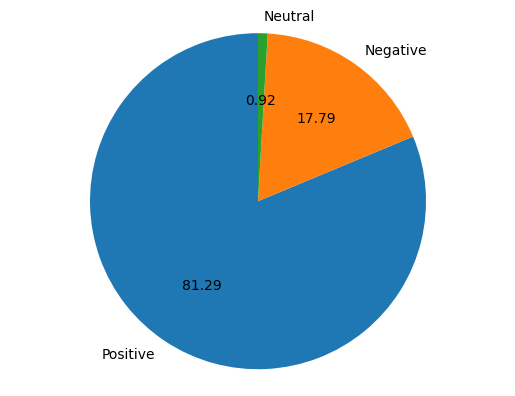

In [25]:
# clasificar la polaridad en categorías 'pos' (positiva), 'neg' (negativa) y 'neu' (neutral)
pos=0
neg=0
neu=0

for items in com['sentiment']:
    if items>0:
        pos=pos+1
    elif items<0:
        neg=neg+1
    else:
        neu=neu+1
        
# Distribución de general de sentimientos en los comentarios
pieLabels=["Positive","Negative","Neutral"]

populationShare=[pos,neg,neu]

figureObject, axesObject = plt.subplots()

axesObject.pie(populationShare,labels=pieLabels,autopct='%1.2f',startangle=90)

axesObject.axis('equal')

plt.show()

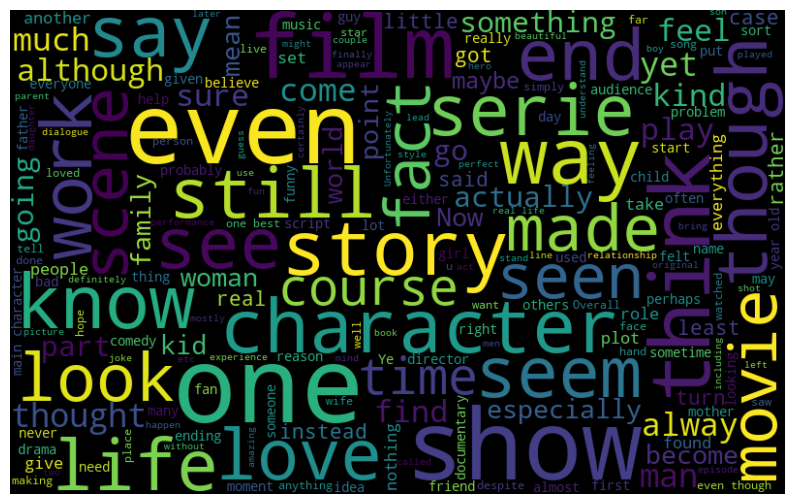

In [26]:
# nube de palabras
from wordcloud import WordCloud

all_words = ' '.join([text for text in com['review']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [3]:
# grafico sunburst de las dos plataformas en conjunto

def filtrar_gen(df, col, thresh):
    counts = df[col].value_counts()
    mask = df[col].isin(counts[counts > thresh].index)
    return df[mask]

film = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

film['genres'] = film['genres'].str.strip('[]').str.replace("'", '').str.split(', ')
film_gen = film['genres'].apply(pd.Series).rename(columns = lambda x : 'genre_' + str(x))

df_sunburst = pd.concat([film_gen['genre_0'], film_gen['genre_1']], axis=1)
df_sunburst.columns = ['Level 1', 'Level 2']

df_sunburst = df_sunburst.dropna(subset=['Level 2'])

df_sunburst = filtrar_gen(df_sunburst, 'Level 2', 40)  
df_sunburst = filtrar_gen(df_sunburst, 'Level 1', 40)

fig = px.sunburst(df_sunburst, path=['Level 1', 'Level 2'], width=600, height=600)

fig.show()

fig.write_html('../images/HBO_gen_sunburst.html')


In [6]:
import pandas as pd
import numpy as np

df_filtrado = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

In [10]:
df_genre

,Genre,Count,0
0,drama,8291.0,NaN
1,comedy,5617.0,NaN
2,thriller,3780.0,NaN
3,action,3219.0,NaN
4,romance,2913.0,NaN
5,crime,2530.0,NaN
6,documentation,2097.0,NaN
7,horror,1596.0,NaN
8,scifi,1484.0,NaN
9,family,1464.0,NaN


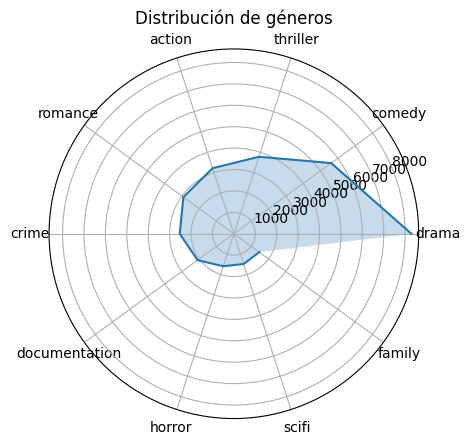

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_filtrado = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

# Obtener la columna de géneros del DataFrame
genres = df_filtrado['genres'].str.split(',').explode().str.strip()

# Calcular la cuenta de cada género
genre_counts = genres.value_counts()

# Obtener los 10 primeros géneros más frecuentes
top_10_genres = genre_counts.head(10)

# Crear un DataFrame con los géneros y sus cuentas
df_genre = pd.DataFrame({'Genre': top_10_genres.index, 'Count': top_10_genres.values})

# Ordenar el DataFrame por las cuentas de forma descendente
df_genre = df_genre.sort_values(by='Count', ascending=False)

# Limitar el DataFrame a los 10 primeros géneros
df_genre = df_genre.head(10)

# Mostrar el gráfico polar de géneros
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
angles = np.linspace(0, 2*np.pi, len(df_genre), endpoint=False)
data = df_genre['Count'].values
ax.plot(angles, data)
ax.fill(angles, data, alpha=0.25)
ax.set_xticks(angles)
ax.set_xticklabels(df_genre['Genre'])
ax.set_title('Distribución de géneros')
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_filtrado = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

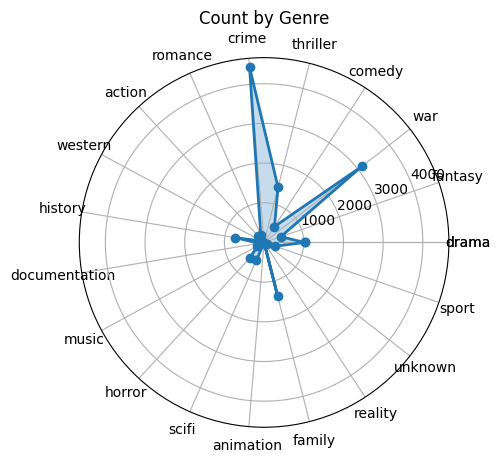

In [6]:
df_filtrado['genres'] = df_filtrado['genres'].str.split(',').str[0]

data = df_filtrado.groupby('genres').count().T.iloc[0]
etiquetas=list(df_filtrado.genres.unique())

angulos = np.linspace(0, 2*np.pi, len(etiquetas), endpoint=False)
angulos=np.concatenate((angulos, [angulos[0]]))

data = np.concatenate((data, [data[0]]))

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angulos, data, 'o-', linewidth=2)   # pinta los datos
ax.fill(angulos, data, alpha=0.25)          # rellena de color
ax.set_xticklabels([])  # quita los nombre de los angulas
ax.set_thetagrids(angulos * 180/np.pi, etiquetas+[etiquetas[0]])  # añadir los generos como etiquetas
ax.set_title('Count by Genre')  # titulo

ax.grid(True);  #añade malla

In [9]:
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

In [10]:
titles

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",United States,-1.0,tt0075314,8.2,808582,40965,8.2,"Netflix, HBO"
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",United States,-1.0,tt0068473,7.7,107673,1001,7.3,Netflix
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",United Kingdom,-1.0,tt0071853,8.2,534486,15461,7.8,Netflix
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,unknown,150,"war, action","United Kingdom, United States",-1.0,tt0061578,7.7,72662,20398,7.6,"Netflix, HBO"
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"comedy, european",United Kingdom,4.0,tt0063929,8.8,73424,17617,8.3,Netflix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15714,tm948025,Hard Luck Love Song,MOVIE,"Jesse, a charismatic but down on his luck trou...",2023,R,104,"drama, thriller, romance, music",United States,-1.0,tt8709338,5.3,444,4299,5.3,Amazon
15715,tm811070,The Man on the Other Side,MOVIE,"It is 1974, and in the Cold War paranoia of Ea...",2023,R,85,"action, drama, thriller","United Kingdom, Singapore, Germany",-1.0,tt8000096,4.6,189,3415,2.0,Amazon
15716,ts382337,Marc Marquez: ALL IN,SHOW,Marc Márquez is facing the toughest decision o...,2023,unknown,33,documentation,Spain,1.0,tt26762647,8.1,74,2893,6.0,Amazon
15717,tm1292884,Hunt,MOVIE,"Arjun is the ACP of Hyderabad, who gets involv...",2023,R,129,"action, thriller, crime",India,-1.0,tt21946058,5.8,1269,4403,4.3,Amazon


In [17]:
com = pd.read_csv('../data/raw/comments.csv', encoding='utf-8', encoding_errors='ignore')

In [21]:
com

,id,review,rating_title
0,tt0075314,Insomniac Vietnam veteran Travis Bickle (Rober...,7/10
1,tt0075314,Travis Bickle is a Vietnam veteran who cannot ...,10/10
2,tt0075314,"Taxi Driver, the classic that made Robert DeNi...",10/10
3,tt0075314,A towering classic of American cinematic power...,10/10
4,tt0075314,"Not only one of Scorsese's best films, but one...",9/10
...,...,...,...
242480,tt23805304,This is one such worst and boring film I watch...,1/10
242481,tt23805304,When such a fun movie with so much laughs and ...,9/10
242482,tt23805304,A superb Malayalam comedy entertainer. I reall...,8/10
242483,tt23805304,He is one of the best actors.... i ve ever see...,10/10


In [27]:
# Mismo proceso con los títulos de las review (por si decido utilizar los títulos de las reviews)

import nltk                         # normalizar las expresiones de los comentarios
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\javir\AppData\Roaming\nltk_data...


True

In [28]:
reviews['review_title'] = reviews['review_title'].str.lower()                   # pasar a minusculas
reviews['review_title'] = reviews['review_title'].str.replace('[^\w\s]', '')    # quitar los signos de puntuación

In [30]:
# Elimina stop words (palabras de detención) y realiza lematización
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

reviews['review_title'] = reviews['review_title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))


In [31]:
reviews

,id,review_title,rating_title
0,tt0075314,classy character study disturbed individual-bu...,7/10
1,tt0075314,wonderfully engaging convincing slide modern m...,10/10
2,tt0075314,lady gentlemen: mr. robert de niro!,10/10
3,tt0075314,still power shock...,10/10
4,tt0075314,"disturbing, powerful, relevant, important",9/10
...,...,...,...
239294,tt23805304,"worst worst worst - please watch waste time, i...",1/10
239295,tt23805304,fun movie great performances. worth time,9/10
239296,tt23805304,worth watching hat off!,8/10
239297,tt23805304,uncle,10/10


In [32]:
# utilizar TextBlob para obtener puntuaciones de sentimiento para cada comentario.
from textblob import TextBlob

reviews['sentiment'] = reviews['review_title'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [33]:
reviews

,id,review_title,rating_title,sentiment
0,tt0075314,classy character study disturbed individual-bu...,7/10,0.100000
1,tt0075314,wonderfully engaging convincing slide modern m...,10/10,0.525000
2,tt0075314,lady gentlemen: mr. robert de niro!,10/10,0.000000
3,tt0075314,still power shock...,10/10,0.000000
4,tt0075314,"disturbing, powerful, relevant, important",9/10,0.150000
...,...,...,...,...
239294,tt23805304,"worst worst worst - please watch waste time, i...",1/10,-0.812500
239295,tt23805304,fun movie great performances. worth time,9/10,0.466667
239296,tt23805304,worth watching hat off!,8/10,0.375000
239297,tt23805304,uncle,10/10,0.000000


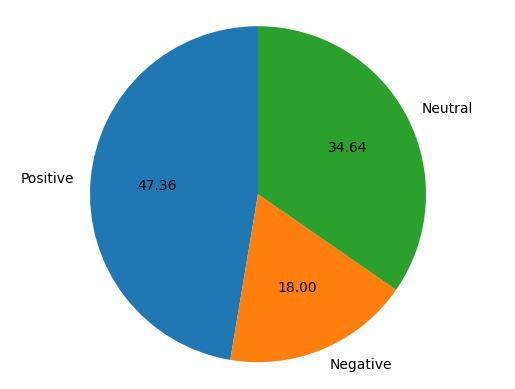

In [36]:
# clasificar la polaridad en categorías 'pos' (positiva), 'neg' (negativa) y 'neu' (neutral)
pos=0
neg=0
neu=0

for items in reviews['sentiment']:
    if items>0:
        pos=pos+1
    elif items<0:
        neg=neg+1
    else:
        neu=neu+1
        
# Distribución de general de sentimientos en los comentarios
pieLabels=["Positive","Negative","Neutral"]

populationShare=[pos,neg,neu]

figureObject, axesObject = plt.subplots()

axesObject.pie(populationShare,labels=pieLabels,autopct='%1.2f',startangle=90)

axesObject.axis('equal')

plt.show()

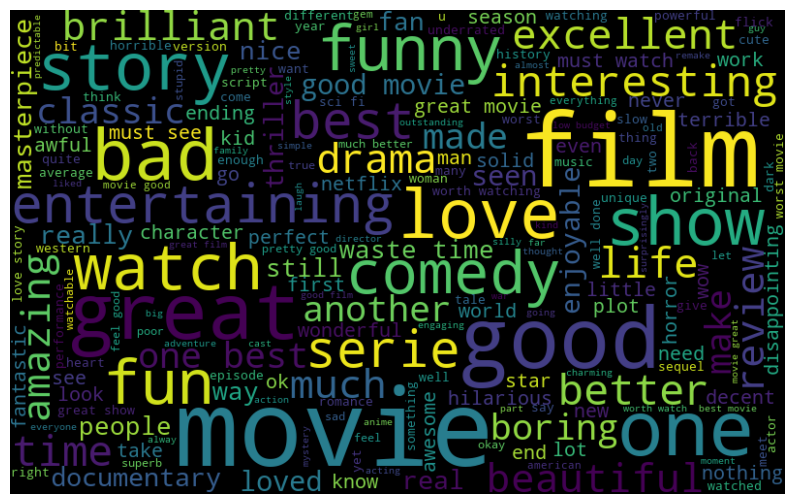

In [40]:
from wordcloud import WordCloud
all_words = ' '.join([text for text in reviews['review_title']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [41]:
reviews.to_csv('../data/raw/reviews2.csv', index=False)

# Backup codes

In [ ]:
st.subheader('¡Prepara palomitas, aquí vienen tus recomendaciones!🍿')
if df_filtrado is not None and not df_filtrado.empty:
    recomendaciones_10 = df_filtrado['title'].tolist()[:10]
    column1, column2 = st.columns(2)  # Divide el espacio en dos columnas
    with column1:
        st.subheader('Recomendaciones')
        for recomendacion in recomendaciones_10:
            st.write(recomendacion)
else:
    st.write('Lo siento, no se encontraron recomendaciones para tus respuestas.')

if df_filtrado is not None and not df_filtrado.empty:
    actor_counts = df_filtrado['actors'].str.split(',').explode().str.strip().value_counts()
    actores_mas_comunes = actor_counts.sort_values(ascending=False).head(10)
    with column2:
        st.subheader('Actores más comunes')
        for actor, count in actores_mas_comunes.items():
            st.write(f'{actor}: {count} apariciones')
else:
    st.write('No se encontraron datos para mostrar.')

In [ ]:
if st.button("Generar recomendaciones"):
    df_filtrado = generar_recomendaciones(respuestas)

    plt.style.use('dark_background')

    # Gráfico de barras del año de lanzamiento
    plt.figure(figsize=(8, 6))
    sns.countplot(x='release_year', data=df_filtrado)
    plt.xlabel('Año de lanzamiento')
    plt.ylabel('Número de películas')
    plt.title('Distribución de películas por año de lanzamiento')
    plt.xticks(rotation=90)
    plt.grid(False)  # Quitar la malla
    st.pyplot()

    # Histograma de duración de las películas
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_filtrado, x='runtime', bins=20, color= 'red')
    plt.xlabel('Duración (minutos)')
    plt.ylabel('Número de películas')
    plt.title('Distribución de duración de las películas')
    plt.grid(False)  # Quitar la malla
    st.pyplot()

In [ ]:
    # Gráfico polar géneros
    df_filtrado['genres'] = df_filtrado['genres'].str.split(',').str[0]
    data = df_filtrado.groupby('genres').count().T.iloc[0]

    etiquetas=list(df_filtrado.genres.unique())
    angulos = np.linspace(0, 2*np.pi, len(etiquetas), endpoint=False)
    angulos=np.concatenate((angulos, [angulos[0]]))
    data = np.concatenate((data, [data[0]]))
    fig = plt.figure()

    ax = fig.add_subplot(111, polar=True)
    ax.plot(angulos, data, 'o-', linewidth=2, color= 'red') 
    ax.fill(angulos, data, alpha=0.25, color= 'red') 
    ax.set_xticklabels([]) 
    ax.set_thetagrids(angulos * 180/np.pi, etiquetas+[etiquetas[0]])  
    ax.set_title('Count by Genre') 
    ax.grid(True, color= '#444444' )
    st.pyplot()
    

    # Gráfico de tarta de la distribución de plataformas
    platform_counts = df_filtrado['platform'].value_counts()
    labels = platform_counts.index.tolist()
    values = platform_counts.values.tolist()

    fig3, ax3 = plt.subplots(figsize=(8, 6))
    ax3.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Distribución de Plataformas')
    st.pyplot(fig3)


In [ ]:
st.subheader('¡Prepara palomitas, aquí vienen tus recomendaciones!🍿')
if df_filtrado is not None and not df_filtrado.empty:
    recomendaciones_10 = df_filtrado['title'].tolist()[:10]
    column1, column2 = st.columns(2)  # Divide el espacio en dos columnas
    with column1:
        st.subheader('Recomendaciones')
        for recomendacion in recomendaciones_10:
            st.write(recomendacion)
else:
    st.write('Lo siento, no se encontraron recomendaciones para tus respuestas.')

In [ ]:

def generar_recomendaciones(respuestas):

    titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')
    comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')


    # 1. Filtro por peli o serie fav
    tfidf = TfidfVectorizer(stop_words= 'english')              # Definir objeto vectorizador TF_IDF
    tfidf_matrix = tfidf.fit_transform(titles['description'])   # contruir matriz TF-IDF

    cosine_sim= linear_kernel(tfidf_matrix, tfidf_matrix)       # similitud de cosenos

    indices= pd.Series(titles.index, index= titles['title']).drop_duplicates()  # construir mapa inverso de indices y titulos de peliculas

    idx = indices[respuestas['pregunta1']]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    movie_id = [i[0] for i in sim_scores]
    df_filtrado = titles.iloc[movie_id]
    df_filtrado = df_filtrado.iloc[1:]

In [ ]:
    # 4. Filtro por actor o actriz favorito
    if respuestas['pregunta4'] != '':
        actor_favorito = respuestas['pregunta4']
        df_filtrado = df_filtrado[df_filtrado['actors'].str.contains(actor_favorito, case=False)]
    else:
        pass


In [ ]:
    # 3. Filtro por tipo de trama favorita
    sinonimos_misterio = ['mystery', 'enigma', 'puzzle', 'riddle', 'conundrum', 'secret', 'intrigue', 'clue', 'suspense']
    sinonimos_aventura = ['thrill', 'adventure', 'expedition', 'journey', 'quest', 'explor', 'trek', 'voyage', 'clue', 'safari', 'exploration']
    sinonimos_fantasia = ['fantasy', 'imagination', 'imaginary', 'enchant', 'magic', 'tail', 'fairy', 'myth', 'wonder', 'dream', 'illusion', 'super', 'superhero']

    if respuestas['pregunta3'] == 'Misterio':
        comentarios_filtrados = comments[comments['review'].apply(lambda x: buscar_sinonimos(x, sinonimos_misterio))]
        df_filtrado = df_filtrado.merge(comentarios_filtrados[['imdb_id']], on='imdb_id', how='inner')
    elif respuestas['pregunta3'] == 'Aventura':
        comentarios_filtrados = comments[comments['review'].apply(lambda x: buscar_sinonimos(x, sinonimos_aventura))]
        df_filtrado = df_filtrado.merge(comentarios_filtrados[['imdb_id']], on='imdb_id', how='inner')
    elif respuestas['pregunta3'] == 'Fantasía':
        comentarios_filtrados = comments[comments['review'].apply(lambda x: buscar_sinonimos(x, sinonimos_fantasia))]
        df_filtrado = df_filtrado.merge(comentarios_filtrados[['imdb_id']], on='imdb_id', how='inner')
    elif respuestas['pregunta3'] == '¡Cualquiera!':
        pass

In [ ]:
 # Título del menú lateral
st.sidebar.title('Buscador de Películas')

titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore')

opciones = ['Buscar Película']
opcion_seleccionada = st.sidebar.selectbox('Selecciona una opción', opciones)

if opcion_seleccionada == 'Buscar Película':
    st.header('Buscador de Películas')

    # Crea un campo de texto para que el usuario ingrese el nombre de la película
    nombre_pelicula = st.text_input('Ingresa el nombre de la película')

    # Filtra el DataFrame para obtener la información de la película ingresada
    pelicula = titles[titles['nombre'].str.contains(nombre_pelicula, case=False)]

    # Verifica si se encontraron resultados
    if not pelicula.empty:
        # Muestra la información de la película
        st.subheader('Información de la Película')
        st.write('Descripción:', pelicula['description'].values[0])
        st.write('Año de Lanzamiento:', pelicula['release_year'].values[0])
        st.write('Género:', pelicula['genres'].values[0])
        st.write('País de Producción:', pelicula['production_countries'].values[0])
        st.write('IMDb Score:', pelicula['imdb_score'].values[0])
    else:
        st.write('No se encontraron resultados para la película ingresada')

## Recomendacion por similitud en las críticas de imdb

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

respuestas= 'Breaking Bad'

def generar_recomendaciones(respuestas):
    df_filtrado = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore') 
    comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

    # 1. Filtro por peli o serie fav
    tfidf = TfidfVectorizer(stop_words='english')              # Definir objeto vectorizador TF-IDF
    tfidf_matrix = tfidf.fit_transform(comments['comment'])   # construir matriz TF-IDF

    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)       # similitud de cosenos

    indices = pd.Series(comments.index, index=comments['title']).drop_duplicates()  # construir mapa inverso de índices y títulos de películas

    idx = indices[respuestas['pregunta1']]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)       # ordenar las películas por similitud de contenido
    movie_id = [i[0] for i in sim_scores]
    df_filtrado = comments.iloc[movie_id]
    df_filtrado = df_filtrado.iloc[1:]

    return df_filtrado


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

respuestas= 'Breaking Bad'

def generar_recomendaciones(respuestas):
    titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore') 
    comments = pd.read_csv('../data/clean/critics.csv', encoding='utf-8', encoding_errors='ignore')

    # 1. Filtro por peli o serie fav
    tfidf = TfidfVectorizer(stop_words='english')              # Definir objeto vectorizador TF-IDF
    tfidf_matrix = tfidf.fit_transform(comments['review'])   # construir matriz TF-IDF

    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)       # similitud de cosenos

    indices = pd.Series(comments.index, index=comments['title']).drop_duplicates()  # construir mapa inverso de índices y títulos de películas

    idx = indices[respuestas]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)       # ordenar las películas por similitud de contenido
    movie_id = [i[0] for i in sim_scores]
    df_filtrado = comments.iloc[movie_id]
    df_filtrado = df_filtrado.iloc[1:]

    return df_filtrado


In [2]:
generar_recomendaciones(respuestas)

,imdb_id,review,title
9377,tt3032476,Had heard nothing but amazing things about 'Be...,Better Call Saul
9211,tt2758692,An other spin-off from the Gold Rush series on...,Yukon Gold
14368,tt9243946,I am generous with a 9 cos I enjoyed this movi...,El Camino: A Breaking Bad Movie
10214,tt4179452,I reviewed this after the first season in 2015...,The Last Kingdom
10864,tt5071412,Season one came out and it had pretty terrific...,Ozark
...,...,...,...
12459,tt6982562,Satire about the miseries of a bunch of wannab...,Nobody Famous
12883,tt7510870,Worst Movie. This was another worst movie of 2...,Sakka Podu Podu Raja
13502,tt8216094,"It follows Penelope, student by day, party gir...",Penélope
13590,tt8328418,"Primitiver Humor, wenn man das überhaupt Humor...",Enissa Amani: Ehrenwort


In [1]:
import pandas as pd

In [2]:
comments = pd.read_csv('../data/clean/comments.csv', encoding='utf-8', encoding_errors='ignore')

In [3]:
comments

,id,review,rating_title
0,tt0075314,Insomniac Vietnam veteran Travis Bickle (Rober...,7/10
1,tt0075314,Travis Bickle is a Vietnam veteran who cannot ...,10/10
2,tt0075314,"Taxi Driver, the classic that made Robert DeNi...",10/10
3,tt0075314,A towering classic of American cinematic power...,10/10
4,tt0075314,"Not only one of Scorsese's best films, but one...",9/10
...,...,...,...
242480,tt23805304,This is one such worst and boring film I watch...,1/10
242481,tt23805304,When such a fun movie with so much laughs and ...,9/10
242482,tt23805304,A superb Malayalam comedy entertainer. I reall...,8/10
242483,tt23805304,He is one of the best actors.... i ve ever see...,10/10


In [4]:
df_filtrado = comments.groupby('id').head(3)

In [5]:
df_filtrado

,id,review,rating_title
0,tt0075314,Insomniac Vietnam veteran Travis Bickle (Rober...,7/10
1,tt0075314,Travis Bickle is a Vietnam veteran who cannot ...,10/10
2,tt0075314,"Taxi Driver, the classic that made Robert DeNi...",10/10
21,tt0068473,I will be the first to acknowledge that althou...,9/10
22,tt0068473,"John Boorman's ""Deliverance"" concerns four sub...",8/10
...,...,...,...
242467,tt21946058,Movie is a remake of Mumbai police malyalam mo...,3/10
242468,tt21946058,The movie pace was interesting during the firs...,7/10
242470,tt23805304,Ennalum Ente Aliya is yet another fun filled c...,8/10
242471,tt23805304,"Positive, one of the best performances of Lena...",7/10


In [6]:
df_filtrado = df_filtrado.groupby('id')['review'].apply(lambda x: ' '.join(x)).reset_index()


In [7]:
df_filtrado

,id,review
0,tt0002199,While this pioneering effort does have some sh...
1,tt0003973,A women finds 4 seeds in an antique chest that...
2,tt0004457,"""The Patchwork Girl of Oz"" was the most racist..."
3,tt0004873,"Before I jump into the review, I have a confes..."
4,tt0005302,It may be considered a slender story and not w...
...,...,...
14771,tt9899340,I honestly love PMY's acting and working ethic...
14772,tt9902160,IN A NUTSHELL:\nA big thank-you to Amazon Stud...
14773,tt9908860,"I enjoyed watching the show, and seeing the ar..."
14774,tt9914972,As someone who was born and raised in Zimbabwe...


In [8]:
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore') 

In [9]:
df_filtrado.rename(columns={'id': 'imdb_id'}, inplace=True)

In [10]:
df_merged = pd.merge(df_filtrado, titles[['imdb_id', 'title']], on='imdb_id', how='left')


In [11]:
df_merged

,imdb_id,review,title
0,tt0002199,While this pioneering effort does have some sh...,From the Manger to the Cross
1,tt0003973,A women finds 4 seeds in an antique chest that...,A Florida Enchantment
2,tt0004457,"""The Patchwork Girl of Oz"" was the most racist...",The Patchwork Girl of Oz
3,tt0004873,"Before I jump into the review, I have a confes...",Alice in Wonderland
4,tt0005302,It may be considered a slender story and not w...,"Fanchon, the Cricket"
...,...,...,...
14771,tt9899340,I honestly love PMY's acting and working ethic...,Her Private Life
14772,tt9902160,IN A NUTSHELL:\nA big thank-you to Amazon Stud...,Herself
14773,tt9908860,"I enjoyed watching the show, and seeing the ar...",Blown Away
14774,tt9914972,As someone who was born and raised in Zimbabwe...,Blind Ambition


In [12]:
df_merged.to_csv('../data/clean/critics.csv', index=False)

In [11]:
#original
def generar_recomendaciones(respuestas):

    titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore') 
    comments = pd.read_csv('../data/clean/com_group.csv', encoding='utf-8', encoding_errors='ignore')

    # 1. Filtro por peli o serie fav
    tfidf = TfidfVectorizer(stop_words= 'english')              # Definir objeto vectorizador TF_IDF
    tfidf_matrix = tfidf.fit_transform(titles['description'])   # contruir matriz TF-IDF

    cosine_sim= linear_kernel(tfidf_matrix, tfidf_matrix)       # similitud de cosenos

    indices= pd.Series(titles.index, index= titles['title']).drop_duplicates()  # construir mapa inverso de indices y titulos de peliculas

    idx = indices[respuestas]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)       #ordenar las peliculas por similitud de contenido
    movie_id = [i[0] for i in sim_scores]
    df_filtrado = titles.iloc[movie_id]
    df_filtrado = df_filtrado.iloc[1:]
    
    return df_filtrado


In [12]:
generar_recomendaciones(respuestas)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,actors
2876,tm455568,Paddleton,MOVIE,An unlikely friendship between two neighbors b...,2019,R,89,"drama, comedy",United States,-1.0,tt8041276,7.1,13791,7339,7.0,Netflix,"Mark Duplass, Ray Romano, Christine Woods, Jen..."
3005,tm818502,"Live Twice, Love Once",MOVIE,A retired academic teacher tries to find the l...,2019,unknown,101,"comedy, drama, european",Spain,-1.0,tt9063902,7.2,6588,14209,7.5,Netflix,"Inma Cuesta, Oscar Martínez, Mafalda Carbonell..."
6216,tm38781,Wit,MOVIE,A renowned professor is forced to reassess her...,2001,PG-13,99,"drama, documentation, european",United States,-1.0,tt0243664,8.0,10993,12739,7.3,HBO,"Emma Thompson, Christopher Lloyd, Eileen Atkin..."
9378,tm192032,The Ride,MOVIE,A has-been cowboy is given a second chance at ...,1997,PG,101,"drama, family, sport, western",United States,-1.0,tt0127247,6.6,494,3595,6.8,Amazon,"Michael Biehn, Clarence Felder, Brock Pierce, ..."
12645,tm448634,Say Yes,MOVIE,A young woman diagnosed with cancer tries to p...,2018,unknown,94,drama,United States,-1.0,tt7217362,6.5,538,2848,4.8,Amazon,"Leah McKendrick, Patrick Zeller, Matt Pascua, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15309,tm1294232,Thankam,MOVIE,Muthu and Kannan are Gold Agents from Thrissur...,2023,unknown,145,"drama, crime",India,-1.0,tt11086194,7.3,2868,5722,8.8,Amazon,"Biju Menon, Vineeth Sreenivasan, Aparna Balamu..."
15310,tm1291792,New Year’s Special,MOVIE,Ingrid Guimarães and Lázaro Ramos hit the grou...,2023,unknown,56,unknown,Brazil,-1.0,tt25753082,6.3,20,675,5.0,Amazon,"Ingrid Guimarães, Lázaro Ramos, Juliette, Maír..."
15311,tm948025,Hard Luck Love Song,MOVIE,"Jesse, a charismatic but down on his luck trou...",2023,R,104,"drama, thriller, romance, music",United States,-1.0,tt8709338,5.3,444,4299,5.3,Amazon,"Michael Dorman, Sophia Bush, RZA, Dermot Mulro..."
15313,ts382337,Marc Marquez: ALL IN,SHOW,Marc Márquez is facing the toughest decision o...,2023,unknown,33,documentation,Spain,1.0,tt26762647,8.1,74,2893,6.0,Amazon,"Marc Márquez, Dani Pedrosa, Jorge Lorenzo, Ale..."


In [1]:
#Versión mejorada: esta función establece relaciones de similitud a través de comentarios de imdb, lo que resulta más ajustado que la similitud de descripciones

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

respuestas= 'Breaking Bad'

def generar_recomendaciones(respuestas):
    titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore') 
    comments = pd.read_csv('../data/clean/critics.csv', encoding='utf-8', encoding_errors='ignore')

    # 1. Filtro por peli o serie fav
    tfidf = TfidfVectorizer(stop_words='english')              # Definir objeto vectorizador TF-IDF
    tfidf_matrix = tfidf.fit_transform(comments['review'])   # construir matriz TF-IDF

    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)       # similitud de cosenos

    indices = pd.Series(comments.index, index=comments['title']).drop_duplicates()  # construir mapa inverso de índices y títulos de películas

    idx = indices[respuestas]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)       # ordenar las películas por similitud de contenido
    movie_id = [i[0] for i in sim_scores]
    df_filtrado = comments.iloc[movie_id]
    df_filtrado = df_filtrado.iloc[1:]
    df_filtrado = df_filtrado.merge(titles.rename(columns={'title': 'title_original'}), on='imdb_id', how='inner')

    return df_filtrado

In [2]:
generar_recomendaciones(respuestas)

,imdb_id,review,title,id,title_original,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,actors
0,tt3032476,Had heard nothing but amazing things about 'Be...,Better Call Saul,ts8,Better Call Saul,SHOW,Six years before Saul Goodman meets Walter Whi...,2015,TV-MA,49,"drama, crime",United States,6.0,8.8,438575,273296,8.5,Netflix,"Bob Odenkirk, Jonathan Banks, Rhea Seehorn, Pa..."
1,tt2758692,An other spin-off from the Gold Rush series on...,Yukon Gold,ts21378,Yukon Gold,SHOW,Five family-run mining camps risk everything i...,2013,unknown,44,reality,Canada,5.0,6.0,655,4256,5.3,Amazon,"Al Mc Gregor, Ken Foy, Guillaume Brodeur, Karl..."
2,tt9243946,I am generous with a 9 cos I enjoyed this movi...,El Camino: A Breaking Bad Movie,tm827648,El Camino: A Breaking Bad Movie,MOVIE,In the wake of his dramatic escape from captiv...,2019,R,123,"crime, drama, thriller, action",United States,-1.0,7.3,216847,42566,6.9,Netflix,"Aaron Paul, Jesse Plemons, Charles Baker, Matt..."
3,tt4179452,I reviewed this after the first season in 2015...,The Last Kingdom,ts36577,The Last Kingdom,SHOW,A show of heroic deeds and epic battles with a...,2015,TV-MA,55,"action, drama, war, history, european",United Kingdom,5.0,8.5,132561,153281,8.3,Netflix,"Alexander Dreymon, Emily Cox, Eliza Butterwort..."
4,tt5071412,Season one came out and it had pretty terrific...,Ozark,ts53864,Ozark,SHOW,A financial adviser drags his family from Chic...,2017,TV-MA,60,"drama, crime, thriller",United States,4.0,8.5,300454,146805,8.2,Netflix,"Jason Bateman, Laura Linney, Sofia Hublitz, Sk..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14440,tt6982562,Satire about the miseries of a bunch of wannab...,Nobody Famous,tm364236,Nobody Famous,MOVIE,A weekend at a cottage takes a turn for the wo...,2018,unknown,87,"comedy, drama",Canada,-1.0,4.6,150,2247,6.2,Amazon,"Winny Clarke, Justin Gerhard, Evan Giovanni, G..."
14441,tt7510870,Worst Movie. This was another worst movie of 2...,Sakka Podu Podu Raja,tm354622,Sakka Podu Podu Raja,MOVIE,A happy-go-lucky-guy falls in love with the si...,2017,unknown,140,"action, comedy, romance",India,-1.0,4.3,468,2538,10.0,Amazon,"Santhanam, Vaibhavi Shandilya, Vivek, VTV Gane..."
14442,tt8216094,"It follows Penelope, student by day, party gir...",Penélope,tm411971,Penélope,MOVIE,"In the Smug art world, innocence perishes. Thi...",2018,unknown,67,"drama, comedy, romance",Argentina,-1.0,5.4,69,1029,5.3,Amazon,"Cumelén Sanz, Sergio Pángaro, Juan Barberini, ..."
14443,tt8328418,"Primitiver Humor, wenn man das überhaupt Humor...",Enissa Amani: Ehrenwort,tm411528,Enissa Amani: Ehrenwort,MOVIE,"Live from Hamburg, Iranian-German comedian Eni...",2018,PG,65,"comedy, european",United States,-1.0,5.5,194,1143,5.6,Netflix,"Enissa Amani, Max Amini"


In [7]:
titles = pd.read_csv('../data/clean/titles.csv', encoding='utf-8', encoding_errors='ignore') 
titles.loc[titles['title'] == 'Better Call Saul']

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_votes,tmdb_score,platform,actors
989,ts8,Better Call Saul,SHOW,Six years before Saul Goodman meets Walter Whi...,2015,TV-MA,49,"drama, crime",United States,6.0,tt3032476,8.8,438575,273296,8.5,Netflix,"Bob Odenkirk, Jonathan Banks, Rhea Seehorn, Pa..."
